# Prepare environment

In [1]:
import torch
from matplotlib import pyplot as plt


from torch.utils.data import DataLoader

from dataset.STARCOP_dataset import STARCOPDataset
from dataset.dataset_info import ClassifierDatasetInfo
from dataset.dataset_type import DatasetType
from files_handler.model_files_handler import ModelFilesHandler
import  os
os.chdir(r"C:\Users\mpilc\Desktop\Studia\Thesis\Repozytoria\Thesis")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load sample images

In [2]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# Visualize inputs

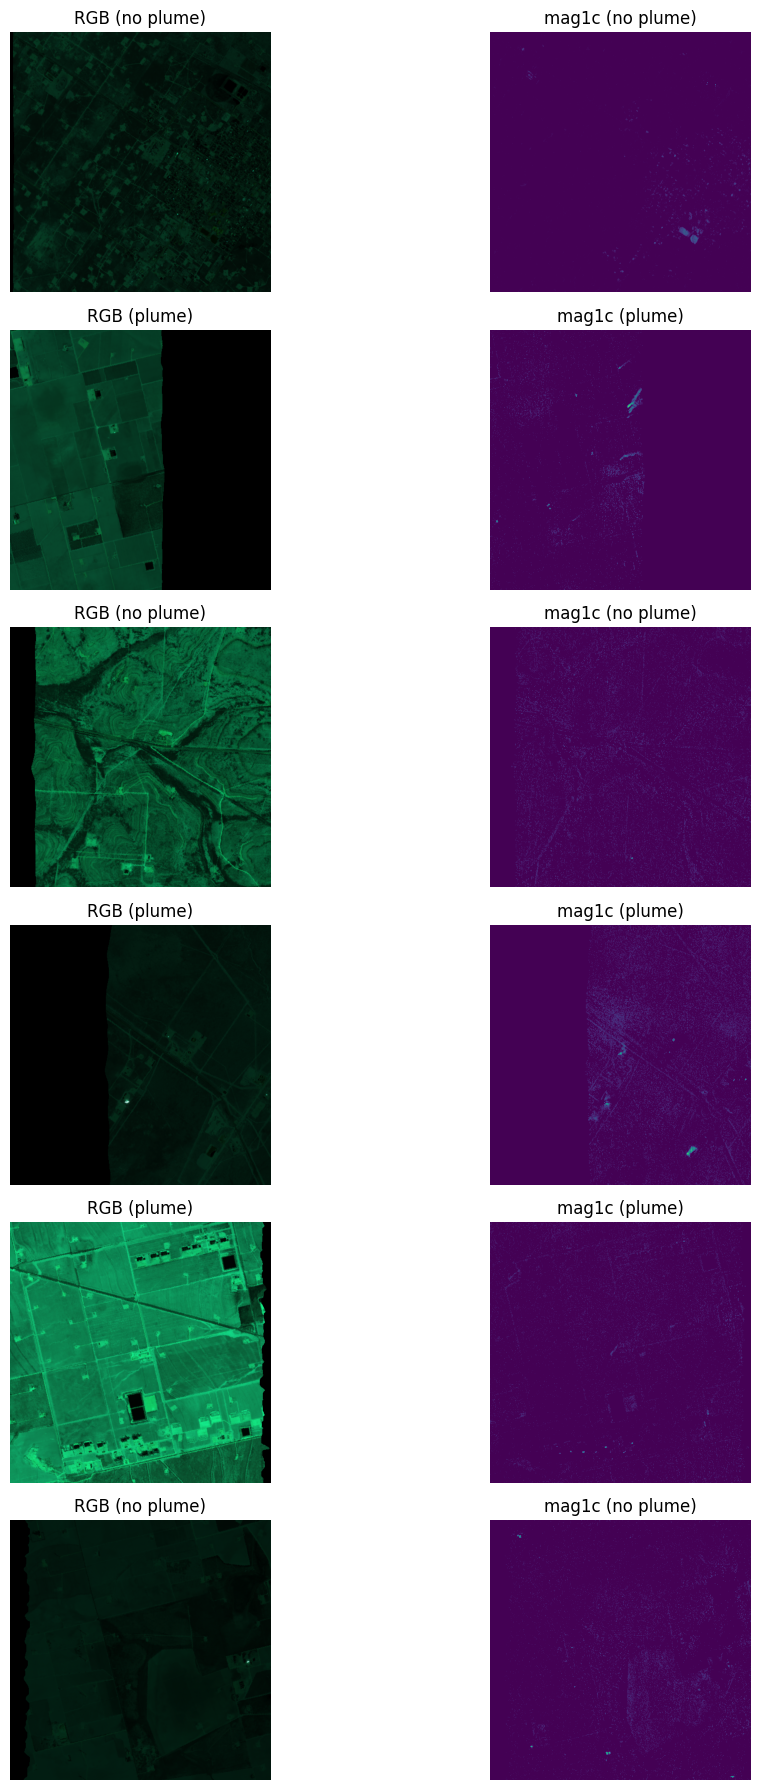

In [3]:
images = next(iter(dataloader))

# Create a figure with subplots
fig, ax = plt.subplots(6, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
for i in range(images[0].shape[0]):
    image_rgb = images[0][i, :3, :, :].permute(1, 2, 0).numpy()
    image_mag1c = images[1][i].squeeze(0).numpy()
    
    image_rgb = image_rgb - image_rgb.min()  # Shift minimum to 0
    image_rgb = image_rgb / image_rgb.max()  # Scale maximum to 1
    
    plume = images[2][i].item()
    ax[i, 0].imshow(image_rgb)
    ax[i, 0].set_title(f"RGB ({"plume" if plume == True else "no plume"})")
    ax[i, 0].axis('off') 
    
    # Display the second image
    ax[i, 1].imshow(image_mag1c)  # Automatically handles RGB
    ax[i, 1].set_title(f"mag1c ({"plume" if plume == True else "no plume"})")
    ax[i, 1].axis('off')  # Turn off axis
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

# Prepare input for model 

In [4]:
input_image = torch.cat((images[0], images[1]), dim=1)
input_image = input_image.to(device)

# Prepare model

In [5]:
file_name = r"trained_models\model_detr_2024_12_15_11_35_17.pickle"

model_handler = ModelFilesHandler()
model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

C:\Users\mpilc\Desktop\Studia\Thesis\Repozytoria\Thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CustomDetrForClassification(
  (detr): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (

# Show performance

In [6]:
outputs = model(input_image.to(device))
print(outputs.shape)
print(outputs)
print(f"Labels:  {images[2].numpy()}")
print(f"Outputs: {torch.argmax(outputs, dim=1).bool().to("cpu").numpy()}")

torch.Size([6, 2])
tensor([[ 0.6346, -0.8706],
        [-0.0630, -0.1859],
        [ 1.6496, -1.8885],
        [-0.4656,  0.1896],
        [ 1.4749, -1.7213],
        [ 1.6438, -1.8785]], device='cuda:0', grad_fn=<AddmmBackward0>)
Labels:  [False  True False  True  True False]
Outputs: [False False False  True False False]


In [7]:
metrics

,TP,FP,FN,TN,Precision,Sensitivity,Specificity,NPV,FPR,Accuracy,F-Score,IoU,MCC,AUC,CI
0,0.375367,0.014663,0.111437,0.498534,0.962404,0.771083,0.971427,0.817306,0.028571,0.873899,0.856185,0.748538,0.760883,0.871256,0.051847


# Visualize backbone

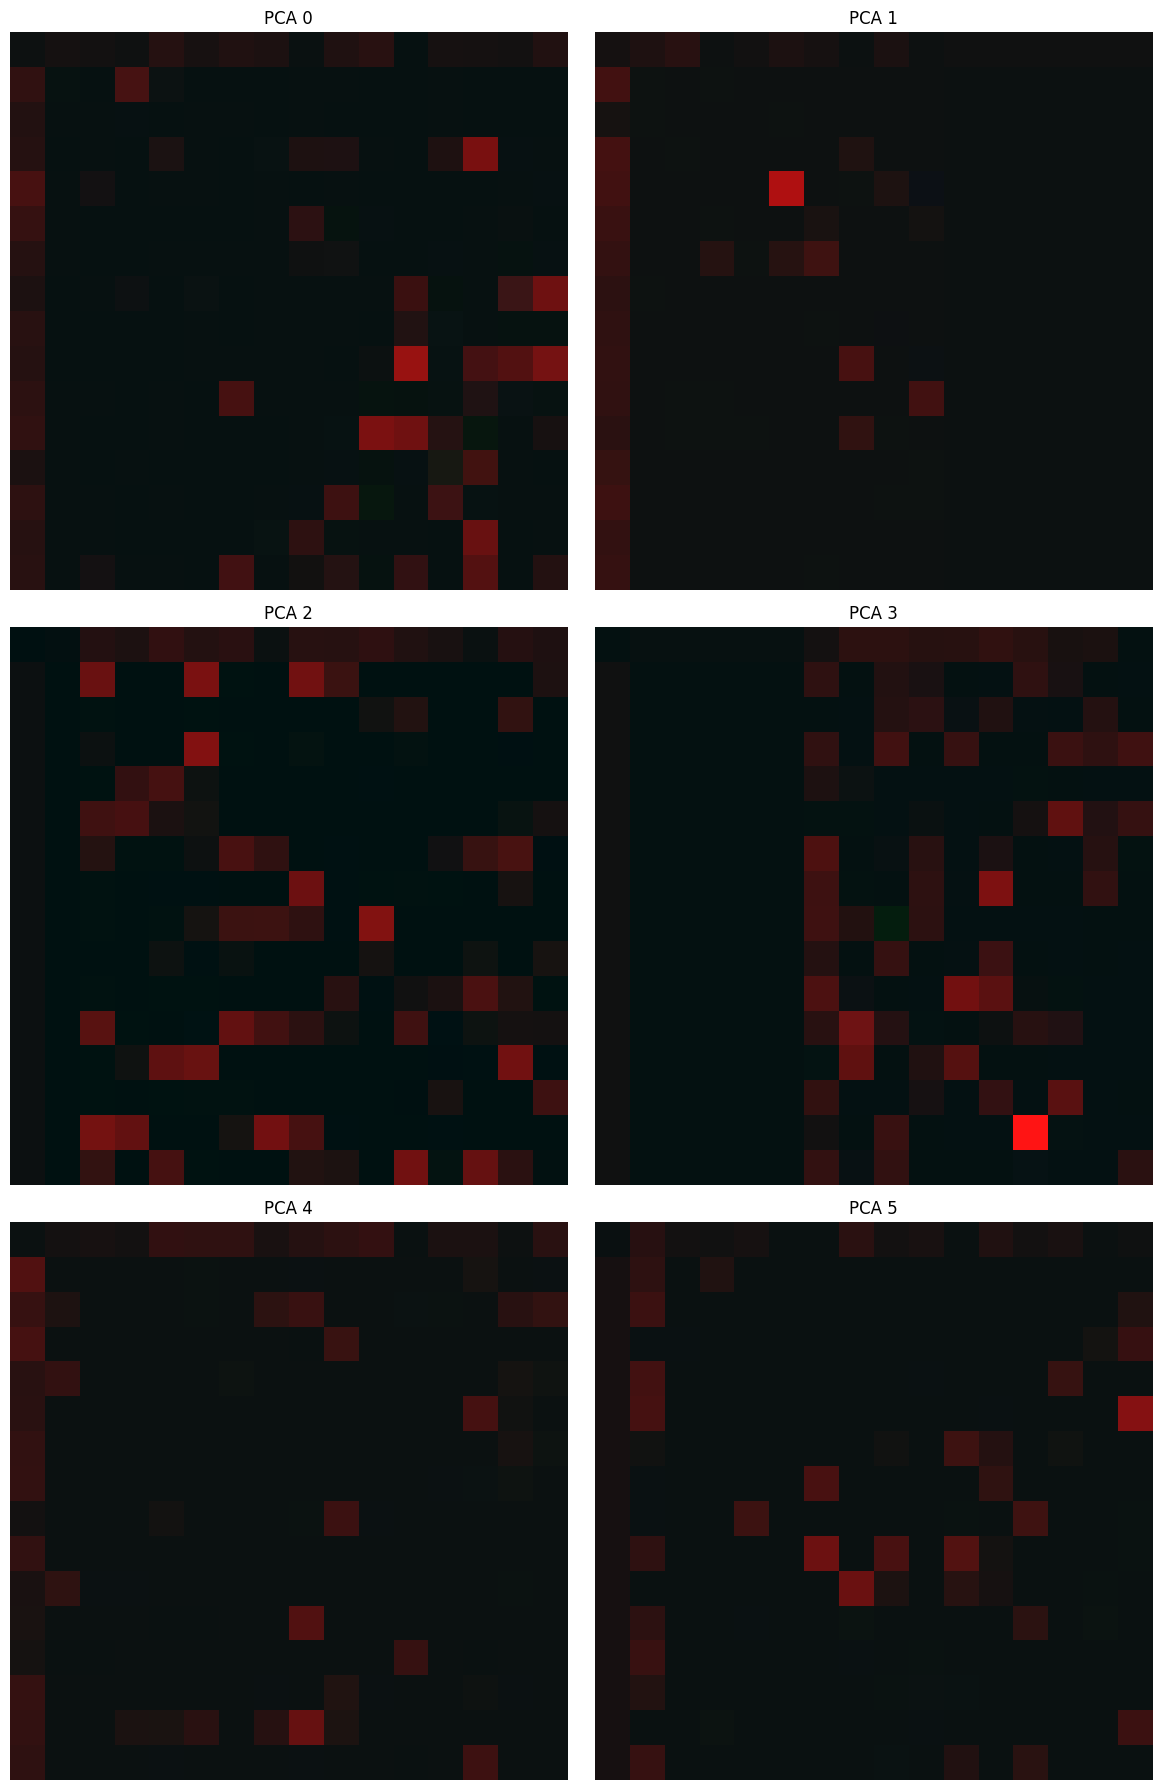

In [8]:
from sklearn.decomposition import PCA

backbone = model.detr.model.backbone

backbone.eval()
backbone.to(device)
result, _ = backbone(input_image.to(device), pixel_mask=torch.ones((6, 512, 512), device=device))


backbone_output = result[3][0].detach().to("cpu")

# Assume `resnet_output` is a PyTorch tensor of shape (batch_size, channels, height, width)
batch, channels, height, width = backbone_output.shape
reduced_outputs = []

for b in range(batch):
    # Extract one sample from the batch
    single_sample = backbone_output[b]  # Shape: (channels, height, width)
    
    # Flatten the spatial dimensions and convert to NumPy
    flattened = single_sample.permute(1, 2, 0).reshape(-1, channels).cpu().numpy()  # Shape: (height * width, channels)
    
    # Apply PCA
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(flattened)  # Shape: (height * width, 3)
    
    # Reshape back and convert to PyTorch
    reduced = torch.tensor(reduced, dtype=torch.float32, device=backbone_output.device)  # Back to PyTorch
    reduced = reduced.view(height, width, 3).permute(2, 0, 1)  # Shape: (3, height, width)
    
    reduced_outputs.append(reduced)

# Stack all processed samples back into a batch
reduced_outputs = torch.stack(reduced_outputs)

# Normalize for visualization
normalized_output = (reduced_outputs - reduced_outputs.min()) / (reduced_outputs.max() - reduced_outputs.min())

# Create a figure with subplots
fig, ax = plt.subplots(3, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
row = 0
for i in range(0, normalized_output.shape[0], 2):
    ax[row, 0].imshow(normalized_output[i].permute(1, 2, 0))
    ax[row, 0].set_title(f"PCA {i}")
    ax[row, 0].axis('off')
    
    ax[row, 1].imshow(normalized_output[i + 1].permute(1, 2, 0))
    ax[row, 1].set_title(f"PCA {i + 1}")
    ax[row, 1].axis('off')
    row += 1
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

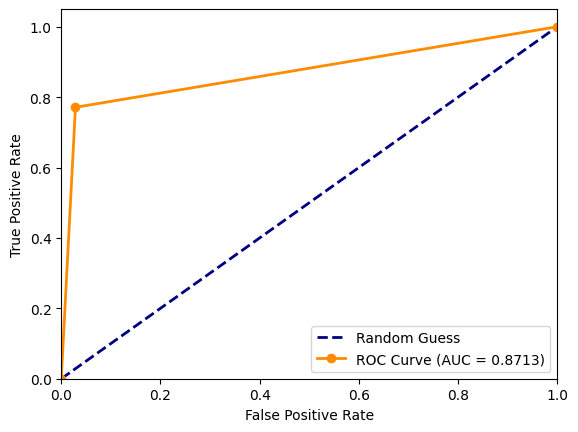

In [9]:
import matplotlib.pyplot as plt

# Example data
fpr = metrics["FPR"] # Replace with your FPR values
tpr = metrics["Sensitivity"]  # Replace with your TPR values

#  Plot the point
fpr_values = [0, fpr.item(), 1]
tpr_values = [0, tpr.item(), 1]

plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')  # Diagonal line
plt.plot(fpr_values, tpr_values, color='darkorange', lw=2, marker='o', label=f'ROC Curve (AUC = {metrics['AUC'].item():.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
